<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [19]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-04-11 08:03:07--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-04-11 08:03:07 (132 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [20]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [21]:
df.shape

(346, 10)

### Convert to date time object


In [22]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [23]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [350]:
# # notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

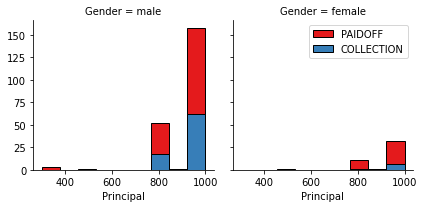

In [24]:
import seaborn as sns
# Multi-plot grid for plotting conditional relationships.
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

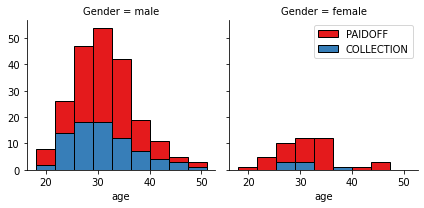

In [25]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


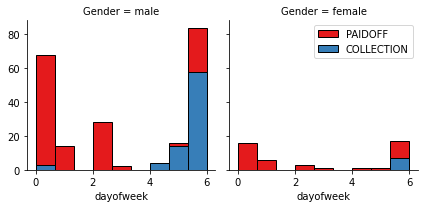

In [27]:
df['dayofweek'] = df['effective_date'].dt.dayofweek

bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [28]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [29]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [30]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [31]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [32]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [33]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [34]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [35]:
df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [36]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
# split -> model -> predict -> evaluate -> visualize

In [41]:
# To optimize the parameters, let's create a validation and training datasets from our data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print('x train set shape: ', x_train.shape)
print('x test set shape: ', x_test.shape)
print('y train set shape: ', y_train.shape)
print('y test set shape: ', y_test.shape)

x train set shape:  (276, 8)
x test set shape:  (70, 8)
y train set shape:  (276,)
y test set shape:  (70,)


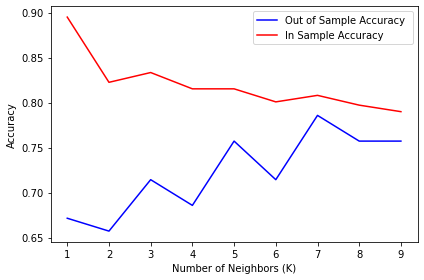

In [44]:
# Run a for loop to discover which k neighbors is the best fit for our model

Ks = 10   # k < 10
test_accuracy = np.zeros((Ks-1)) 
train_accuracy = np.zeros((Ks-1))

for k in range(1, Ks):
    knn = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train)
    y_hat = knn.predict(x_test)
    test_accuracy[k-1] = metrics.accuracy_score(y_test, y_hat)
    train_accuracy[k-1] = metrics.accuracy_score(y_train, knn.predict(x_train))

plt.plot(range(1,Ks),test_accuracy,'b')
plt.plot(range(1,Ks),train_accuracy,'r')
plt.legend(('Out of Sample Accuracy ', 'In Sample Accuracy'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()    

In [46]:
print('The best out of sample accuracy was: %.4f' % test_accuracy.max(), "with k =", test_accuracy.argmax()+1)

The best out of sample accuracy was: 0.7857 with k = 7


# Decision Tree


In [48]:
from sklearn.tree import DecisionTreeClassifier

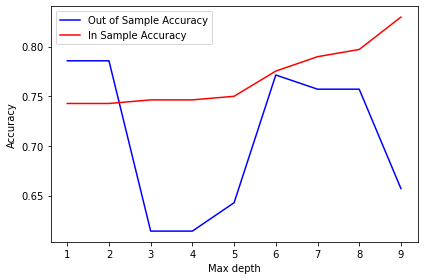

In [49]:
depths = 10
test_accuracy = np.zeros((depths-1))
train_accuracy = np.zeros((depths-1))

for k in range(1, depths):
    DT = DecisionTreeClassifier(criterion="entropy", max_depth=k)
    DT.fit(x_train, y_train)
    y_hat = DT.predict(x_test)
    train_accuracy[k-1] = metrics.accuracy_score(y_train, DT.predict(x_train))
    test_accuracy[k-1] = metrics.accuracy_score(y_test, y_hat)

plt.plot(range(1,Ks), test_accuracy,'b')
plt.plot(range(1,Ks), train_accuracy,'r')
plt.legend(('Out of Sample Accuracy', 'In Sample Accuracy'))
plt.ylabel('Accuracy')
plt.xlabel('Max depth')
plt.tight_layout()
plt.show()    

The figure shows that the best Decision Tree's accuracy is when tree's depth = 6. 
(The model seems underfitting when max_depth <=2)

In [53]:
print("Decision Tree's Accuracy when max_depth equals 6 is: %.3f" % test_accuracy[5])

Decision Tree's Accuracy when max_depth equals 6 is: 0.771


# Support Vector Machine


In [55]:
from sklearn import svm

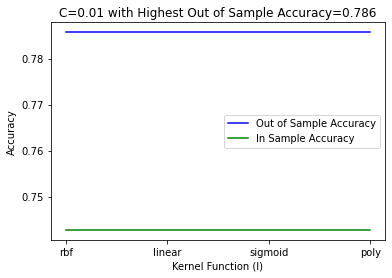

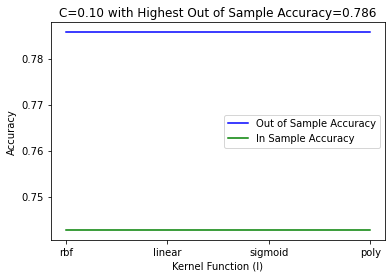

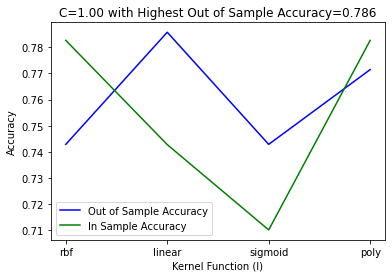

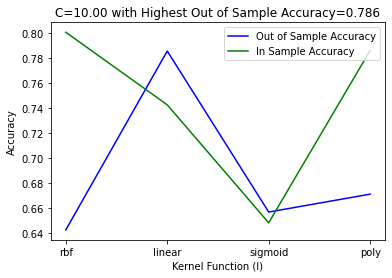

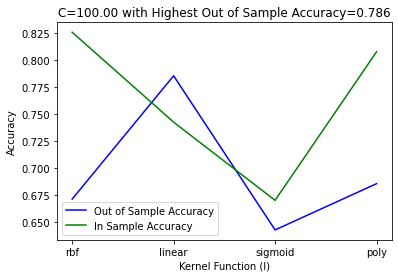

In [65]:
# Run two nested for loops to compare different Kernel Function and regularization parameter C
kernelfunc = ['rbf', 'linear', 'sigmoid', 'poly']
C_range = [0.01, 0.1, 1, 10, 100]
test_accuracy = np.zeros(len(kernelfunc))
train_accuracy = np.zeros(len(kernelfunc))

for c in C_range:
    for i in range(len(kernelfunc)):
        SVM = svm.SVC(C=c, kernel=kernelfunc[i]).fit(x_train, y_train)
        y_hat = SVM.predict(x_test)
        test_accuracy[i] = metrics.accuracy_score(y_test, y_hat)
        train_accuracy[i] = metrics.accuracy_score(y_train, SVM.predict(x_train))
    plt.plot(kernelfunc, test_accuracy, 'b')
    plt.plot(kernelfunc, train_accuracy, 'g')
    plt.legend(('Out of Sample Accuracy', 'In Sample Accuracy'))
    plt.title('C=%.2f' % c + ' with Highest Out of Sample Accuracy=%.3f' % test_accuracy.max())
    plt.ylabel('Accuracy')
    plt.xlabel('Kernel Function (I)')
    plt.tight_layout
    plt.show()

The first two figures show test accuracy much higher than training accuracy, implying excessive regularization (C is too small).
The last three figures show that using linear kernel function gives the highest test accuracy, 
although it is still higher than the training accuracy.
Since the difference is small, and accuracy score is substantially higher than other functions, we conclude that
the best kernel function for our SVM model is linear and C=10, with test accuracy equals to 0.786.

# Logistic Regression


In [62]:
from sklearn.linear_model import LogisticRegression

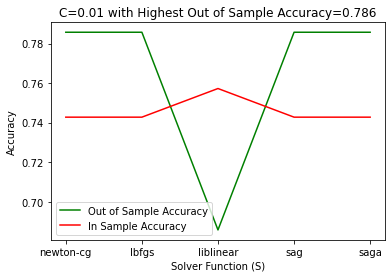

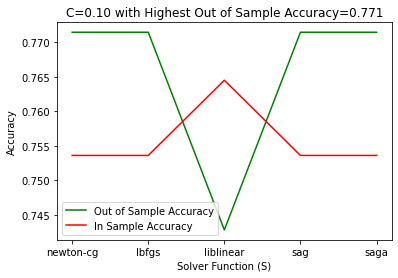

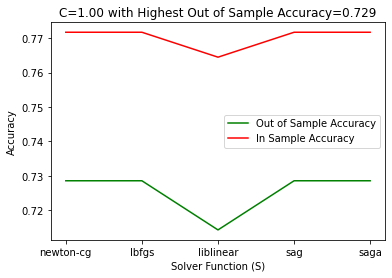

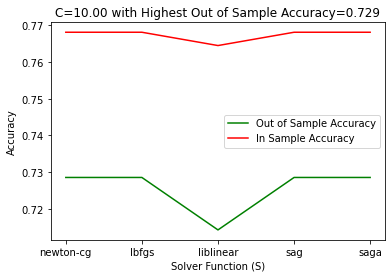

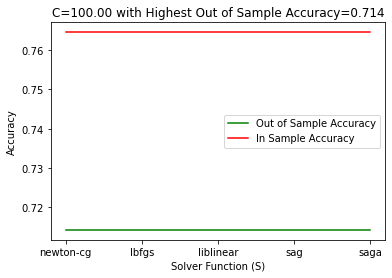

In [66]:
# Use two nested for loops to compare different solver functions and regularization parameters

solverfunc = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
C_range = [0.01, 0.1, 1, 10, 100]
test_accuracy = np.zeros(len(solverfunc))
train_accuracy = np.zeros(len(solverfunc))

for c in C_range:
    for s in range(len(solverfunc)):
        LR = LogisticRegression(C=c, solver=solverfunc[s], max_iter=10000).fit(x_train, y_train)
        y_hat = LR.predict(x_test)
        test_accuracy[s] = metrics.accuracy_score(y_test, y_hat)
        train_accuracy[s] = metrics.accuracy_score(y_train, LR.predict(x_train))
        
    plt.plot(solverfunc, test_accuracy, 'g')
    plt.plot(solverfunc, train_accuracy, 'r')
    plt.legend(('Out of Sample Accuracy', 'In Sample Accuracy'))
    plt.ylabel('Accuracy')
    plt.xlabel('Solver Function (S)')
    plt.title('C=%.2f' % c + ' with Highest Out of Sample Accuracy=%.3f' % test_accuracy.max())
    plt.show()


In [69]:
# From the first two figures, only liblinear seems to be a good choice for solver function (test accuracy much higher than training accuracy in the rest)
LR = LogisticRegression(C=0.01, solver='liblinear', max_iter=10000).fit(x_train, y_train)
print("Accuracy Score for C=0.01, solver='liblinear': %.3f" % metrics.accuracy_score(y_test, LR.predict(x_test)))
LR = LogisticRegression(C=0.1, solver='liblinear', max_iter=10000).fit(x_train, y_train)
print("Accuracy Score for C=0.1, solver='liblinear':  %.3f" % metrics.accuracy_score(y_test, LR.predict(x_test)))
# The last three figures show that when C >= 1, all solver functions but liblinear produce similar and highest test accuracy.
LR = LogisticRegression(C=1, solver='lbfgs', max_iter=10000).fit(x_train, y_train)
print("Accuracy Score for C=1, solver='lbfgs': %.3f" % metrics.accuracy_score(y_test, LR.predict(x_test)))

Accuracy Score for C=0.01, solver='liblinear': 0.686
Accuracy Score for C=0.1, solver='liblinear':  0.743
Accuracy Score for C=1, solver='lbfgs': 0.729


From the validation results it seems that C=0.1, solver='liblinear' is the best choice for this model.

# Model Evaluation using Test set


In [70]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [71]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-04-11 09:41:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-04-11 09:41:11 (68.1 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [78]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [79]:
# Pre-process data

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0) #binarilization
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [80]:
# Create feaures
feature = test_df[['Principal','terms','age','Gender','weekend']]
feature = pd.concat([feature,pd.get_dummies(test_df['education'])], axis=1)
feature.drop(['Master or Above'], axis = 1,inplace=True)
feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [81]:
# Normalize data
x_test= preprocessing.StandardScaler().fit(feature).transform(feature)
x_test[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [82]:
# Create y_test data

test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
y_test = test_df['loan_status'].values
y_test[0:5]

array([1, 1, 1, 1, 1])

### K-Nearest Neighbors

In [86]:
# Choose n_neighbors=7 for our model based on evaluating results above
KNN = KNeighborsClassifier(n_neighbors=7).fit(x_train, y_train)
y_pred = KNN.predict(x_test)
print('Jaccard Index: %.4f' % jaccard_score(y_test, y_pred, pos_label=1))
print('F1 Score:%.4f'% f1_score(y_test, y_pred, average='weighted'))

Jaccard Index: 0.6538
F1 Score:0.6328


### Decision Tree

In [87]:
# Choose max_depth=6 for our model based on evaluating results above
DT = DecisionTreeClassifier(criterion='entropy', max_depth=6).fit(x_train, y_train)
y_pred = DT.predict(x_test)
print('Jaccard Index: %.4f' %  jaccard_score(y_test, y_pred, pos_label=1))
print('F1 Score: %.4f' % f1_score(y_test, y_pred, average='weighted'))

Jaccard Index: 0.7115
F1 Score: 0.6705


### Support Vector Machine

In [90]:
# Choose C=10, kernel='linear' for our model based on evaluating results above
SVM = svm.SVC(C=10, kernel='linear', probability=True).fit(x_train, y_train)
y_pred =SVM.predict(x_test)
y_pred_prob = SVM.predict_proba(x_test)
print('Jaccard Index: %.4f' % jaccard_score(y_test, y_pred, pos_label=1))
print('F1 Score: %.4f' % f1_score(y_test, y_pred, average='weighted'))
print('Log Loss: %.4f' %  log_loss(y_test, y_pred_prob))

Jaccard Index: 0.7407
F1 Score: 0.6304
Log Loss: 0.5720


### Logistic Regression

In [92]:
# Choose C=0.1, solver='liblinear' for our model based on evaluating results above
LR = LogisticRegression(C=0.1, solver='liblinear').fit(x_train, y_train)
y_pred = LR.predict(x_test)
y_pred_prob = LR.predict_proba(x_test)
print('Jaccard Index: %.4f' % jaccard_score(y_test, y_pred, pos_label=1))
print('F1 Score: %.4f' % f1_score(y_test, y_pred, average='weighted'))
print('Log Loss: %.4f' % log_loss(y_test, y_pred_prob))

Jaccard Index: 0.7547
F1 Score: 0.6718
Log Loss: 0.4777


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
